# Multi-clasificación: Imágenes satelitales

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [33]:
import fastai as fai
import fastai.vision as fv
import torch
import pandas as pd
import gc

## Bajar y explorar los datos

En esta lección vamos a usar datos de este concurso de kaggle: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data

Afortunadamente, fast.ai trae una pequeña muestra de estos datos como ejemplo. Vamos a usar estos para hacer pruebas. Posteriormente entrenaremos con el dataset completito. LLegaremos un puntaje de 93.1 más o menos, con un solo modelo. El ganador de ese concurso obtuvo 93.3.

Para ver todos los datasets que trae de ejemplo, escribe: `fastai.URLs.`(tab). 

Usaremos `PLANET_SAMPLE`

In [3]:
fai.URLs.PLANET_SAMPLE

'http://files.fast.ai/data/examples/planet_sample'

In [4]:
planet = fai.untar_data(fai.URLs.PLANET_SAMPLE)

In [5]:
planet

PosixPath('/home/mraggi/.fastai/data/planet_sample')

Entonces, si queremos ver qué formato tienen los datos, debemos explorar esa carpeta, que es donde los bajó por alguna razón

In [6]:
!ls {planet}

labels.csv  models  train


Posiblemente ustedes no tengan lo de "models": ese lo creará fast.ai solito después

In [7]:
!head {planet}/labels.csv

image_name,tags
train_21983,partly_cloudy primary
train_9516,clear cultivation primary water
train_12664,haze primary
train_36960,clear primary
train_5302,haze primary road
train_13350,clear primary
train_19547,agriculture clear primary road
train_31388,partly_cloudy primary
train_32079,partly_cloudy primary


In [8]:
!ls {planet}/train | head

train_10001.jpg
train_10007.jpg
train_10030.jpg
train_10033.jpg
train_10042.jpg
train_1004.jpg
train_10075.jpg
train_10082.jpg
train_10084.jpg
train_10098.jpg
ls: write error: Broken pipe


Interesante! Entonces el archivo `labels.csv` tiene el nombre del archivo, luego varias propiedades como `partly_cloudy` o `clear` o `road` o lo que sea. Además, no viene ya partido en "train" y "valid"

## Preparando los datos

Afortunadamente, fast.ai tiene ya incluida una manera de leer datos de una csv. Por detrás de las cortinas utiliza pandas. Podríamos hacerlo nosotros mismos (de hecho lo haremos depués), pero por ahora usemos lo que ya trae

In [9]:
tfms = fv.get_transforms(flip_vert=True, max_rotate=360, max_lighting=0.1, max_zoom=1.05,max_warp=0.05)

In [10]:
def load_planet_data(img_size, batch_size):
    return (fv.ImageItemList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
              .random_split_by_pct(0.2, seed=666) #pct = percentage
              .label_from_df(sep=' ') #dataframe
              .transform(tfms, size=img_size)
              .databunch(bs=batch_size)
              .normalize(fv.imagenet_stats))

In [12]:
data = load_planet_data(128, 64)

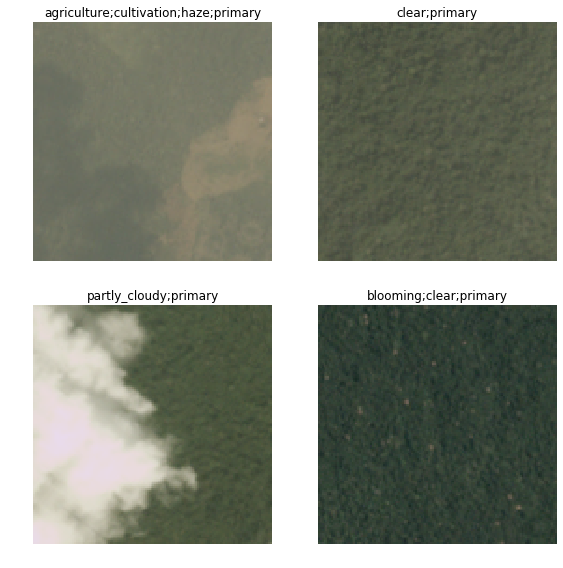

In [13]:
data.show_batch(rows=2)

## Medidas
En el concurso de kaggle evalúan en base al [puntaje f2](https://en.wikipedia.org/wiki/F1_score), así que tendremos que definir nuestra propia medida. Veamos cómo está implementado accuracy para saber qué hacer.


In [14]:
fai.accuracy??

Signature: fai.accuracy(input: torch.Tensor, targs: torch.LongTensor) -> <function NewType.<locals>.new_type at 0x7f40e56dd378>
Source:   
def accuracy(input:Tensor, targs:LongTensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()
File:      ~/.local/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


In [15]:
fai.fbeta??

Signature: fai.fbeta(y_pred: torch.Tensor, y_true: torch.Tensor, thresh: float = 0.2, beta: float = 2, eps: float = 1e-09, sigmoid: bool = True) -> <function NewType.<locals>.new_type at 0x7f40e56dd378>
Source:   
def fbeta(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    "Computes the f_beta between `y_pred` and `y_true` in a multi-classification task."
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()
File:      ~/.local/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


In [16]:
def f2_score_01(input, target):
    return fai.metrics.fbeta(input, target, thresh=0.1, beta=2)
def f2_score_02(input, target):
    return fai.metrics.fbeta(input, target, thresh=0.2, beta=2)
def f2_score_025(input, target):
    return fai.metrics.fbeta(input, target, thresh=0.25, beta=2)
def f2_score_03(input, target):
    return fai.metrics.fbeta(input, target, thresh=0.3, beta=2)
def f2_score_04(input, target):
    return fai.metrics.fbeta(input, target, thresh=0.4, beta=2)

In [17]:
metrics = [f2_score_01, f2_score_02, f2_score_025, f2_score_03, f2_score_04]
learn = fv.create_cnn(data, fv.models.resnet50, metrics=metrics)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


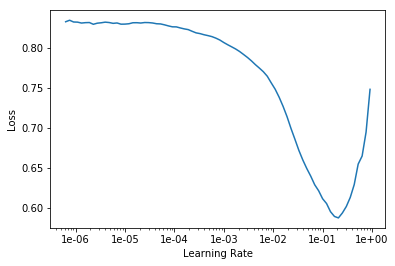

In [18]:
learn.lr_find(); learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.650402,0.476652,0.484562,0.576621,0.638914,0.677139,0.681685
2,0.404460,0.752191,0.555293,0.533397,0.527686,0.515839,0.505248
3,0.312113,0.216825,0.793743,0.820314,0.817381,0.817825,0.802316
4,0.256547,0.144869,0.862496,0.877963,0.876578,0.873016,0.860787
5,0.220105,0.127802,0.889166,0.892455,0.886256,0.880829,0.864595


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


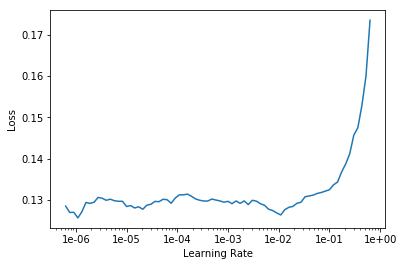

In [20]:
learn.lr_find(); learn.recorder.plot()

In [21]:
learn.fit_one_cycle(5, max_lr=4e-3)

epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.129595,0.124037,0.894577,0.904282,0.892792,0.888796,0.869064
2,0.127613,0.119013,0.900541,0.906937,0.900400,0.888694,0.873542
3,0.123401,0.115299,0.906116,0.911995,0.905950,0.895136,0.881780
4,0.121719,0.114841,0.909853,0.901928,0.902444,0.898302,0.870682
5,0.120126,0.114830,0.909536,0.904900,0.902672,0.893995,0.873878


In [ ]:
torch.save(learn.model.state_dict(), "planet/models/stage-1-r50.pth")

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


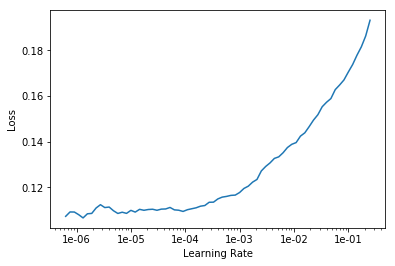

In [23]:
learn.lr_find(); learn.recorder.plot()

In [24]:
learn.fit_one_cycle(8, max_lr=slice(3e-5,8e-4))

epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.115930,0.112291,0.908532,0.913628,0.906366,0.901095,0.872032
2,0.115064,0.117572,0.899455,0.906335,0.906620,0.902709,0.883093
3,0.116101,0.124432,0.898633,0.899719,0.885352,0.871956,0.861414
4,0.113831,0.120553,0.897750,0.895685,0.896062,0.885288,0.874696
5,0.109370,0.125474,0.896703,0.881660,0.872815,0.873114,0.849389
6,0.106434,0.112556,0.912348,0.906887,0.898359,0.892802,0.880824
7,0.102605,0.111230,0.911366,0.911796,0.898591,0.896257,0.882021
8,0.100908,0.110341,0.912150,0.911484,0.906911,0.894776,0.882217


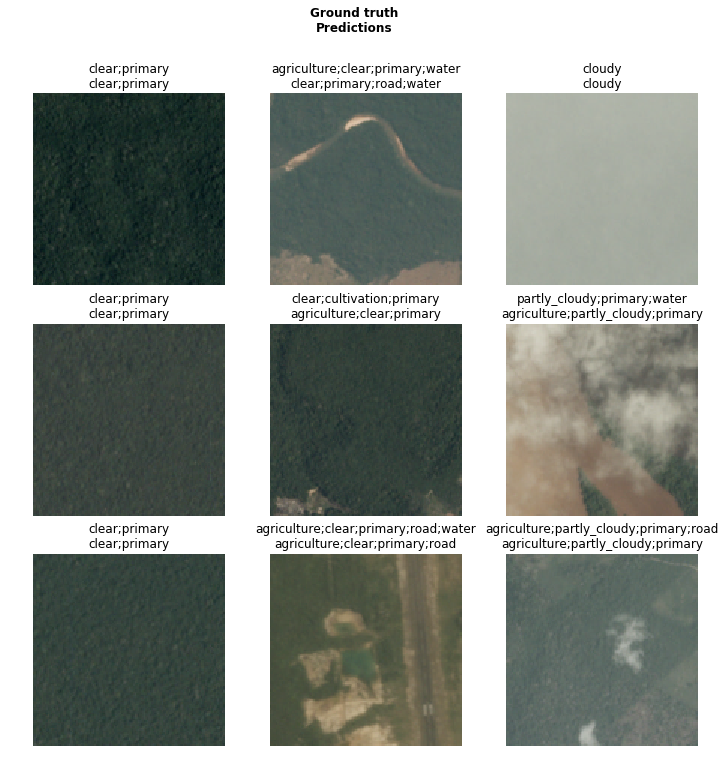

In [25]:
learn.show_results(rows=3)

In [29]:
learn.save("stage-2-r50")

In [31]:
img_sizes = [160, 192, 224, 256]
batch_sizes = [64, 64, 48, 32]

In [34]:
lr = 1e-3
for sz, bs in zip(img_sizes, batch_sizes):
    learn.data = load_planet_data(sz,bs)
    gc.collect()
    learn.fit_one_cycle(8, slice(lr/10, lr))
    learn.save(f"stage3-r50-{sz}")

epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.092447,0.110971,0.910647,0.911892,0.902536,0.899335,0.885807
2,0.095182,0.134894,0.876001,0.889983,0.889974,0.883988,0.878543
3,0.103266,0.143139,0.887271,0.881509,0.873601,0.871465,0.867416
4,0.104518,0.139433,0.879879,0.885715,0.885686,0.879399,0.868249
5,0.105167,0.137491,0.903624,0.892717,0.882651,0.882277,0.857551
6,0.103218,0.119516,0.897678,0.896467,0.894723,0.890312,0.871082
7,0.098630,0.112108,0.906562,0.908080,0.900888,0.887263,0.884904
8,0.095087,0.111358,0.911018,0.903702,0.904749,0.892958,0.880819


epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.085695,0.109862,0.911647,0.909564,0.906509,0.896439,0.886650
2,0.083493,0.109301,0.918423,0.915982,0.908661,0.901927,0.888617
3,0.085041,0.168760,0.866936,0.855480,0.856694,0.844714,0.832014
4,0.090738,0.125990,0.881312,0.890967,0.882662,0.883747,0.869823
5,0.091483,0.107573,0.907691,0.918395,0.914168,0.910323,0.904285
6,0.089030,0.109717,0.913063,0.920087,0.915191,0.906357,0.883410
7,0.086121,0.106743,0.918962,0.907495,0.908874,0.908984,0.890920
8,0.082100,0.106124,0.920031,0.911065,0.906854,0.902217,0.884308


epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.079345,0.107574,0.919208,0.912115,0.907631,0.903054,0.892115
2,0.083180,0.160169,0.886502,0.875354,0.864372,0.854592,0.842825
3,0.090765,0.170674,0.881134,0.880895,0.876080,0.873891,0.873094
4,0.095101,0.127955,0.898005,0.890585,0.889530,0.883971,0.881954
5,0.093463,0.118429,0.903636,0.906595,0.896074,0.896751,0.879625
6,0.089449,0.119058,0.910679,0.899618,0.898645,0.896591,0.882837
7,0.083926,0.114341,0.910452,0.904637,0.904550,0.898113,0.880086
8,0.079254,0.111999,0.911842,0.905940,0.908134,0.899340,0.888081


epoch,train_loss,valid_loss,f2_score_01,f2_score_02,f2_score_025,f2_score_03,f2_score_04
1,0.074257,0.111871,0.917013,0.910959,0.908117,0.901565,0.886773
2,0.081551,0.147348,0.888722,0.881271,0.875470,0.867471,0.859694
3,0.103029,0.173515,0.851206,0.847815,0.840802,0.824447,0.811429
4,0.105535,0.119734,0.898389,0.902251,0.899672,0.897237,0.896003
5,0.103325,0.112437,0.913828,0.901093,0.893913,0.886937,0.875219
6,0.095307,0.107709,0.916188,0.910146,0.901164,0.898749,0.879712
7,0.086830,0.101317,0.919023,0.919069,0.914625,0.904735,0.888159
8,0.080437,0.102144,0.915243,0.915896,0.913816,0.905923,0.891091


Estamos entrenando con una muy pequeña parte de los datos. Podemos llegar a 93.1 si entrenamos con todo.